<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.01 ms, sys: 1.18 ms, total: 2.18 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel.

We'll wrap the `inc` and `add` functions in the `dask.delayed` decorator. When we call the delayed version by passing the arguments, the original function isn't actually called yet.
Instead, a *task graph* is built up, representing the *delayed* function call.

In [3]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.37 ms, sys: 1.11 ms, total: 2.49 ms
Wall time: 8.46 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`.

In [7]:
type(y)

dask.delayed.Delayed

In [8]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 7.64 ms, sys: 4.19 ms, total: 11.8 ms
Wall time: 2.02 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result.  We can compute the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [9]:
z

Delayed('add-e44e2f11-d7bc-47ba-93b4-d10aa55bb626')

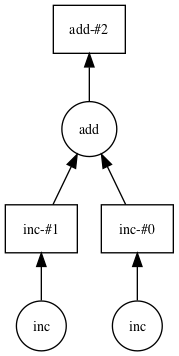

In [10]:
# Look at the task graph for `z`
z.visualize()

Circles are functions, boxes are intermediate results. As you see, the functions are run in parallel (the 2 parameters are loaded in prallel)

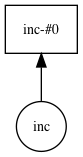

In [12]:
x.visualize()

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [11]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [13]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 11.5 ms, sys: 4.1 ms, total: 15.6 ms
Wall time: 8.02 s


In [14]:
total

44

In [23]:
%%time
results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
val = total.compute()
print(val)

44
CPU times: user 5.86 ms, sys: 3.3 ms, total: 9.16 ms
Wall time: 1.01 s


In [27]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-0c2853fa-3a64-4598-941e-a9c1e362b9db')
After computing : 44
CPU times: user 7.26 ms, sys: 3.43 ms, total: 10.7 ms
Wall time: 1.01 s


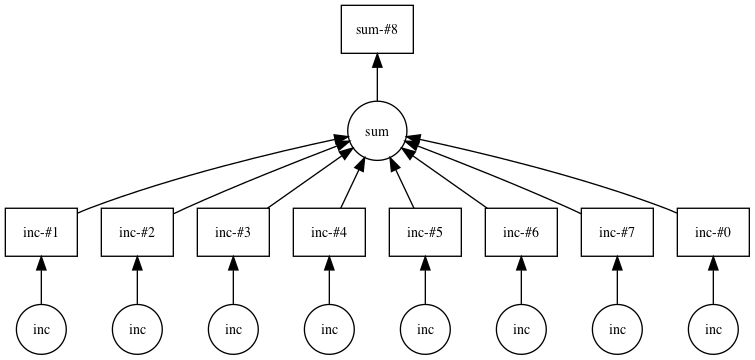

In [28]:
total.visualize()

In [30]:
type(delayed(sum))

dask.delayed.DelayedLeaf

In [31]:
dleaf = delayed(sum)

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [33]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [34]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 15.1 ms, sys: 5.12 ms, total: 20.2 ms
Wall time: 10 s


In [35]:
%%time

resutls = []
for x in data:
    if is_even(x): # you dont call delayed on condition checking code as we dont know the value
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
val = total.compute()
print(val)

180
CPU times: user 8.51 ms, sys: 3.64 ms, total: 12.2 ms
Wall time: 2.01 s


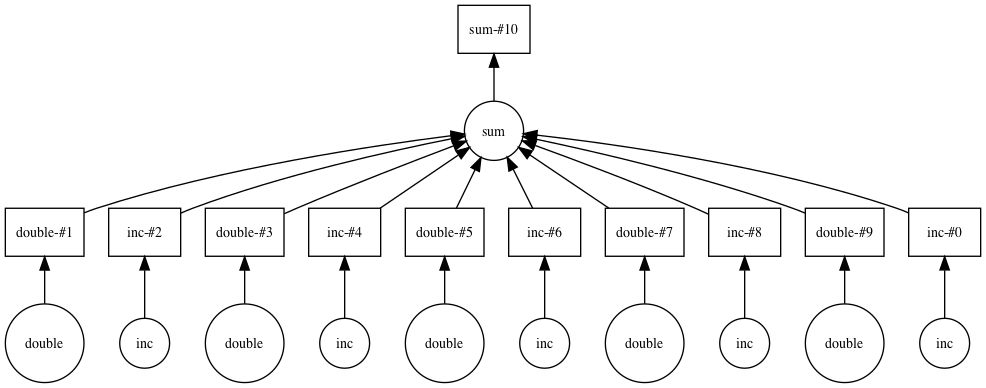

In [36]:
total.visualize()

In [ ]:
%load solutions/01-delayed-control-flow.py

In [ ]:
%time total.compute()

In [ ]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

### Prep data

First, run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [ ]:
%run prep_data.py

### Inspect data

In [37]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [38]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [39]:
df.shape

(271539, 23)

In [40]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [41]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [42]:
df.Origin.value_counts()

EWR    117938
LGA    106448
JFK     47153
Name: Origin, dtype: int64

In [43]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [44]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

Read each csv in sequential mode

In [45]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 9.56 s, sys: 1.29 s, total: 10.9 s
Wall time: 10.3 s


In [46]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [47]:
from dask import compute

In [48]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin') # you dont have to call delayed on groupby as df is delayed by now and
#                                     # all derivatives off that are also delayed.
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 8.35 ms, sys: 9.65 ms, total: 18 ms
Wall time: 15.4 ms


**note**: You typically write delayed inside a loop and not outside it.</note>

In [50]:
%%time
mean.compute()

CPU times: user 11.8 s, sys: 1.77 s, total: 13.6 s
Wall time: 3.22 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [51]:
# %load solutions/01-delayed-groupby.py
# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?